In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from tqdm import tqdm

In [2]:
input_file_path = '../../../siads591 data/processed_data/gabbard/gabbard_36H20.pkl'
freq = '36H'

output_file_path = './gabbard_debris_36H20_60fps.mp4'

In [3]:
bitrate = 1000
dpi = 300
fps = 60
use_slice = slice(None, None, None) # 2 ways to slice the data, this is index slicing for the date range

In [4]:
df = pd.read_pickle(f'{input_file_path}')
df = df[(df.index >= "1980-01-01") & (df.index <= "2021-01-20")] # manually set min/max range based on datetime
display(df.info())
display(df.head(4))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60236232 entries, 1987-12-22 00:00:00 to 2021-01-19 12:00:00
Data columns (total 4 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   NORAD_CAT_ID   uint16
 1   PERIOD_x500    UInt16
 2   APOAPSIS_x20   UInt16
 3   PERIAPSIS_x20  UInt16
dtypes: UInt16(3), uint16(1)
memory usage: 1.1 GB


None

,NORAD_CAT_ID,PERIOD_x500,APOAPSIS_x20,PERIAPSIS_x20
1987-12-22 00:00:00,12,63999,65535,11141
1987-12-23 12:00:00,12,63999,65535,11144
1987-12-25 00:00:00,12,63999,65535,11146
1987-12-26 12:00:00,12,63999,65535,11144


In [5]:
dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)
dates = dates[use_slice]
print(f'{len(dates)} frames')

9997 frames


100%|██████████| 9998/9998 [56:40<00:00,  2.94it/s]  


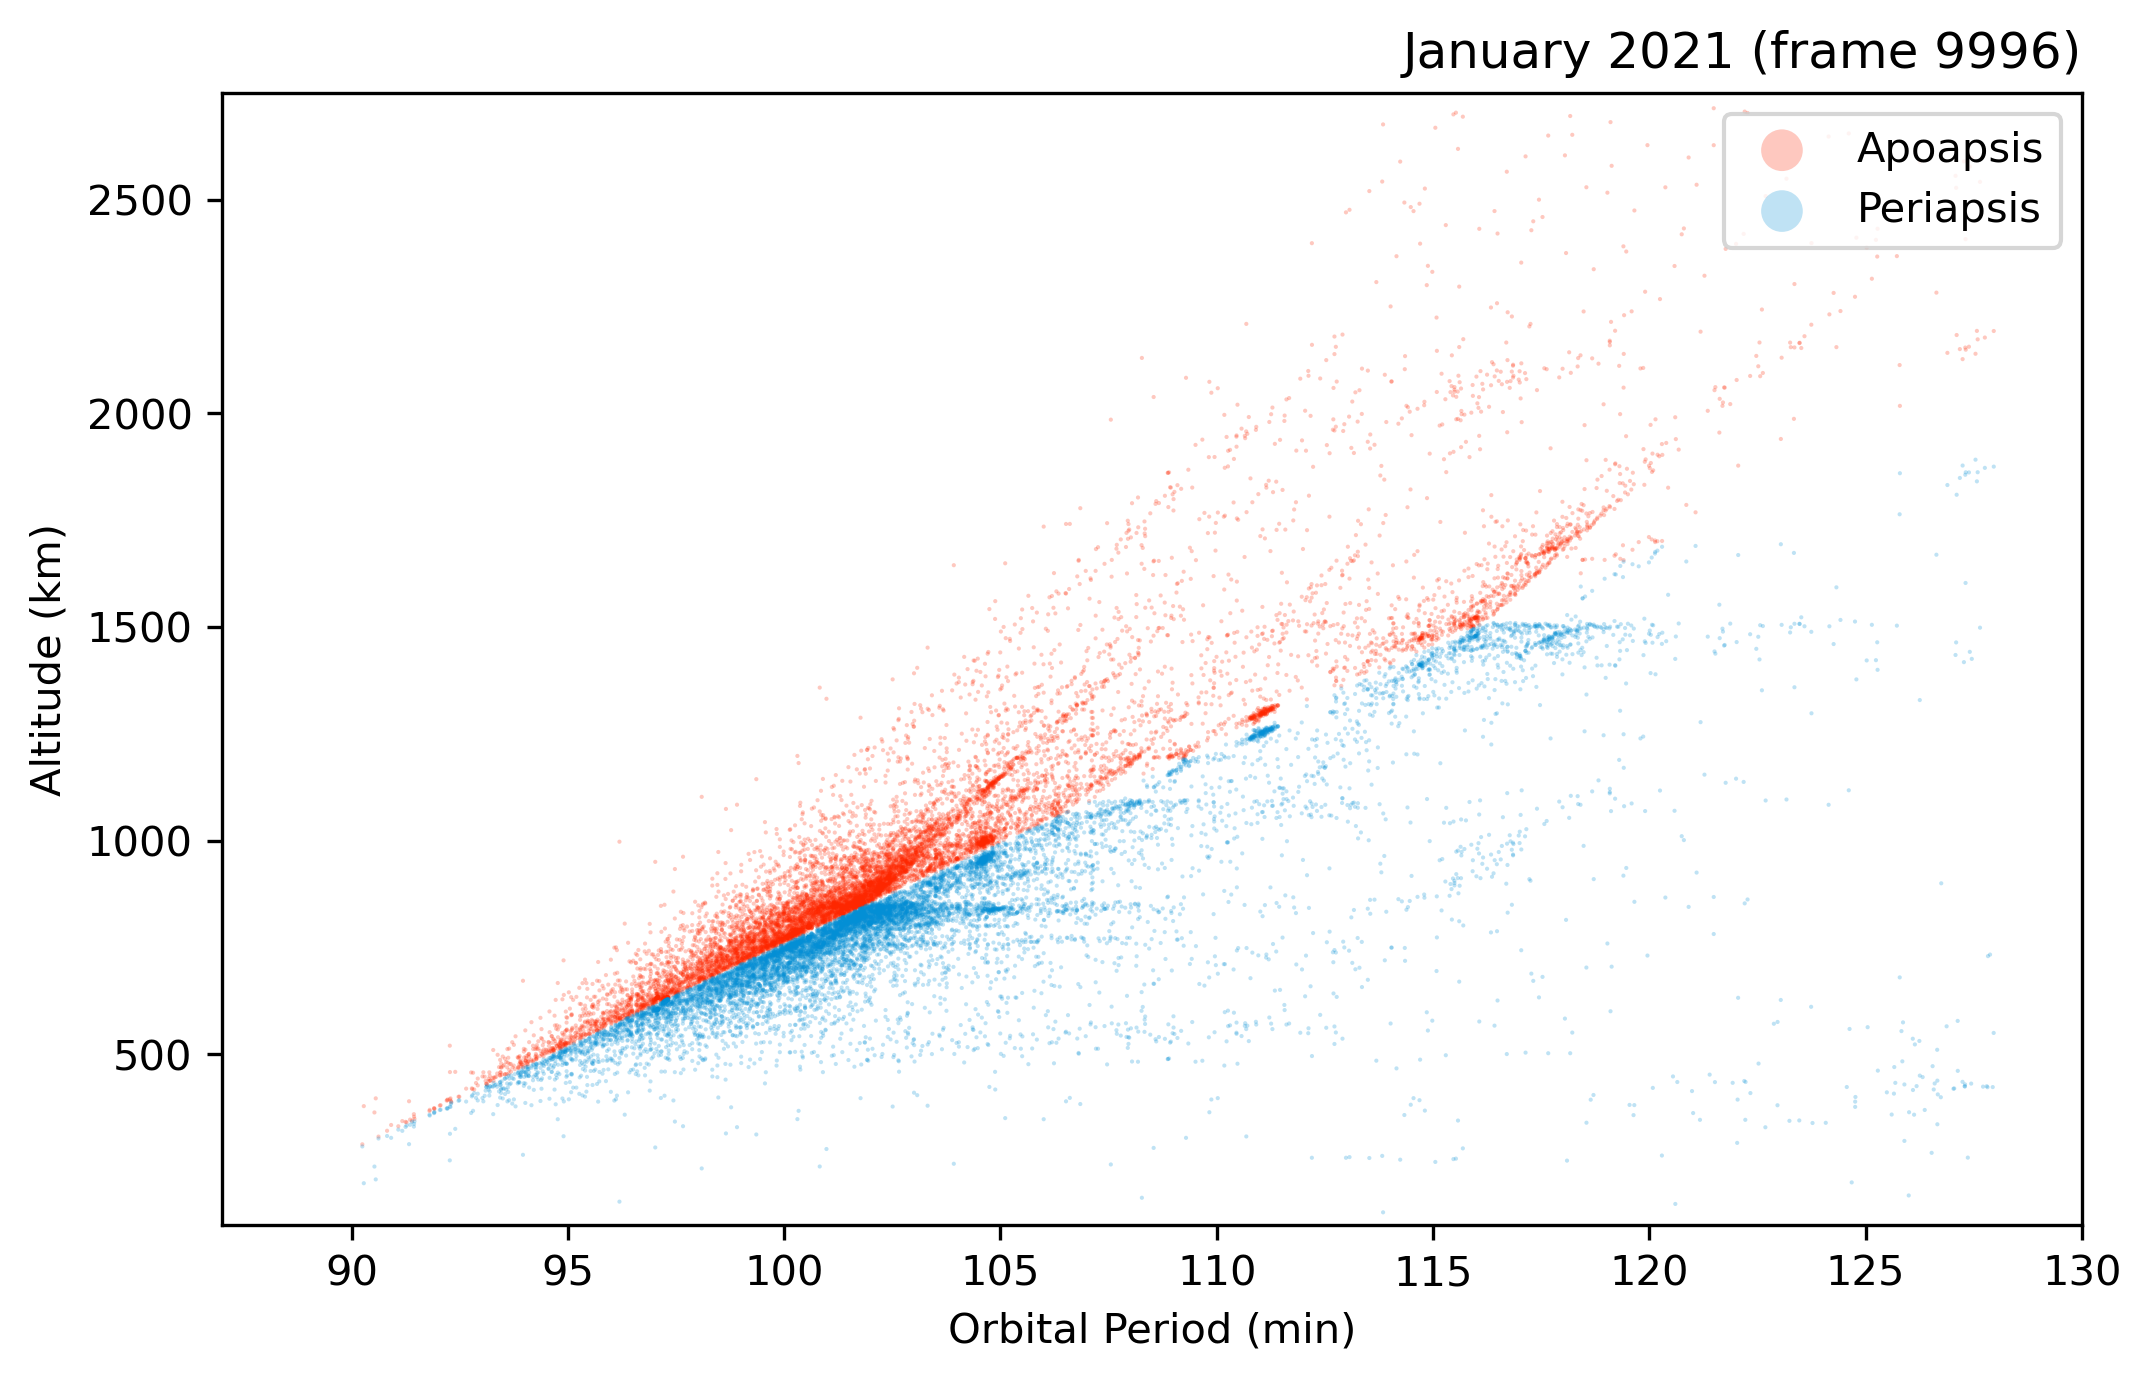

In [6]:
# set this to a specific frame number to draw only 1 frame in the notebook to test output
# Set None to generate full video
draw_one_frame = None

fig, ax = plt.subplots(dpi=dpi, figsize=(8,5))

ax.set_xlim(87,130)
ax.set_ylim(100,2750)
ax.set_xlabel("Orbital Period (min)")
ax.set_ylabel("Altitude (km)")
artists = []

def plot_it(ax,e):
    global df
    cdf = df[df.index==e]
    # revert the scaling of the data
    period_series = cdf.PERIOD_x500.astype(np.float64) / 500
    apoapsis_series = cdf.APOAPSIS_x20.astype(np.float64) / 20
    periapsis_series = cdf.PERIAPSIS_x20.astype(np.float64) / 20
    
    apo = ax.scatter(period_series, apoapsis_series, color='#fe2700', marker='o', edgecolors='none', alpha=0.25, s=1, label="Apoapsis")
    peri = ax.scatter(period_series, periapsis_series, color='#038fd5', marker='o', edgecolors='none', alpha=0.25, s=1, label="Periapsis")
    plt.legend(loc="upper right", numpoints=1, fontsize=10, markerscale=10)
    return [apo,peri]

def update(f):
    global pbar, artists, yr
    i, date = f
    ax.set_title(f"{date.month_name()} {date.year} (frame {i})", loc='right')
    for a in artists:
        a.remove()
    artists = plot_it(ax,date)
    pbar.update(1)

if type(draw_one_frame) == int:
    update((draw_one_frame,dates[draw_one_frame]))
else:
    pbar = tqdm(total=len(dates)+1)
    ani = FuncAnimation(fig, update, list(enumerate(dates)))
    writervideo = FFMpegWriter(fps=fps, bitrate=bitrate)
    ani.save(f'{output_file_path}', writer=writervideo, dpi=dpi)
    pbar.close()